In [22]:
import pandas as pd
import numpy as np
import os

In [23]:
df = pd.read_csv('new_data.csv')

In [24]:
# create a variable called current day
current_day = pd.to_datetime('today').date()

# convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date']).dt.date

# create a new df filter out the rows where the date is greater than the current day
model_df = df[df['Date'] < current_day]

In [25]:
model_df['Attendance'] = model_df['Attendance'].fillna(0) # setting null values to 0 because the NaN are from Covid-19 games with no attendance

model_df['Attendance'] = model_df['Attendance'].astype(int)

/var/folders/ky/0j3p160j7vl9mg1glj79h0q40000gn/T/ipykernel_67213/3374579801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Attendance'] = model_df['Attendance'].fillna(0) # setting null values to 0 because the NaN are from Covid-19 games with no attendance
/var/folders/ky/0j3p160j7vl9mg1glj79h0q40000gn/T/ipykernel_67213/3374579801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Attendance'] = model_df['Attendance'].astype(int)


In [26]:
# remove rows with NaN values
model_df = model_df.dropna()

In [27]:
model_df[['home_goals', 'away_goals']] = model_df['Score'].str.split('–', expand=True).astype(int)

# rename xG and xG.1 columns to home_xG and away_xG
model_df.rename(columns={'xG': 'home_xg', 'xG.1': 'away_xg'}, inplace=True)

In [28]:
def get_result(row):
    if row['home_goals'] > row['away_goals']:
        return 'Home Win'
    elif row['home_goals'] < row['away_goals']:
        return 'Away Win'
    else:
        return 'Draw'
    
model_df['Result'] = model_df.apply(get_result, axis=1)

In [29]:
model_df['Day'] = pd.to_datetime(model_df['Date']).dt.day_name()

model_df['Season'] = model_df['Season'].apply(lambda x: x.split('-')[1])

In [30]:
model_df.reset_index(drop=True, inplace=True)

In [31]:
for x in model_df.Home.unique():
    temp_df = model_df[(model_df['Home'] == x) | (model_df['Away'] == x)]
    temp_df = temp_df.sort_values(['Date'])

    temp_df['goal_value_to_calculate'] = temp_df.apply(lambda y: y['home_goals'] if y['Home'] == x else y['away_goals'], axis=1)
    temp_df['rolling_avg_goals'] = temp_df['goal_value_to_calculate'].rolling(window = 5, closed = 'left', min_periods = 1).mean()

    for index, row in temp_df.iterrows():
        if row['Home'] == x:
            model_df.at[index, 'home_rolling_avg_goals'] = row['rolling_avg_goals']
        else:
            model_df.at[index, 'away_rolling_avg_goals'] = row['rolling_avg_goals']

In [32]:
for x in model_df.Home.unique():
    temp_df = model_df[(model_df['Home'] == x) | (model_df['Away'] == x)]
    temp_df = temp_df.sort_values(['Date'])

    temp_df['xg_value_to_calculate'] = temp_df.apply(lambda y: y['home_xg'] if y['Home'] == x else y['away_xg'], axis=1)
    temp_df['rolling_avg_xG'] = temp_df['xg_value_to_calculate'].rolling(window = 5, closed = 'left', min_periods = 1).mean()

    for index, row in temp_df.iterrows():
        if row['Home'] == x:
            model_df.at[index, 'home_rolling_avg_xG'] = row['rolling_avg_xG']
        else:
            model_df.at[index, 'away_rolling_avg_xG'] = row['rolling_avg_xG']

In [33]:
model_df = model_df.dropna(subset=['home_rolling_avg_goals', 'away_rolling_avg_goals', 'home_rolling_avg_xG', 'away_rolling_avg_xG'])

In [34]:
# create a new column for the central moving average of the home goals
model_df['home_goals_cma'] = model_df['home_goals'].expanding().mean()
model_df['home_xg_cma'] = model_df['home_xg'].expanding().mean()

# away goals
model_df['away_goals_cma'] = model_df['away_goals'].expanding().mean()
model_df['away_xg_cma'] = model_df['away_xg'].expanding().mean()

# create a new column by dividing the home goals by central moving average
model_df['home_goals_div_cma'] = model_df['home_goals'] / model_df['home_goals_cma']
model_df['home_xg_div_cma'] = model_df['home_xg'] / model_df['home_xg_cma']

# away goals
model_df['away_goals_div_cma'] = model_df['away_goals'] / model_df['away_goals_cma']
model_df['away_xg_div_cma'] = model_df['away_xg'] / model_df['away_xg_cma']

In [35]:
# set Wk column to integer
model_df['Wk'] = model_df['Wk'].astype(int)

# create a new column called quarter. divide the season into 4 quarters using the Wk column and assign a value between 1 and 4
model_df['quarter'] = np.where(model_df['Wk'].astype(int) <= 9, 1,
                np.where(model_df['Wk'].astype(int) <= 18, 2,
                np.where(model_df['Wk'].astype(int) <= 27, 3, 4)))

# using home_goals_div_cma, take the mean of the column for each quarter. put into new column called home_goals_seasonality
model_df['home_goals_seasonality'] = model_df.groupby('quarter')['home_goals_div_cma'].transform('mean')
model_df['home_xg_seasonality'] = model_df.groupby('quarter')['home_xg_div_cma'].transform('mean')

# away goals
model_df['away_goals_seasonality'] = model_df.groupby('quarter')['away_goals_div_cma'].transform('mean')
model_df['away_xg_seasonality'] = model_df.groupby('quarter')['away_xg_div_cma'].transform('mean')

# create a new column called home_goals_deseasonalised by dividing home_goals by home_goals_seasonality
model_df['home_goals_deseasonalised'] = model_df['home_goals'] / model_df['home_goals_seasonality']
model_df['home_xg_deseasonalised'] = model_df['home_xg'] / model_df['home_xg_seasonality']

# away goals
model_df['away_goals_deseasonalised'] = model_df['away_goals'] / model_df['away_goals_seasonality']
model_df['away_xg_deseasonalised'] = model_df['away_xg'] / model_df['away_xg_seasonality']

In [36]:
model_df['Season'] = model_df['Season'].astype(int)
# set home goals and away goals to integer
model_df['home_goals'] = model_df['home_goals'].astype(int)
model_df['away_goals'] = model_df['away_goals'].astype(int)

In [37]:
# Ensure 'Result' is categorical or integer-based
model_df['Result'] = model_df['Result'].astype('category')  # or use int depending on your encoding

# Ensure 'home_goals' and 'away_goals' are integers
model_df['home_goals'] = pd.to_numeric(model_df['home_goals'], errors='coerce').fillna(0).astype(int)
model_df['away_goals'] = pd.to_numeric(model_df['away_goals'], errors='coerce').fillna(0).astype(int)

In [38]:
# import packages for random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [41]:
features = [column for column in model_df.drop(columns=[
    'Date', 'Day', 'Home', 'Away', 'Venue', 'Time', 'home_xg', 'away_xg', 'home_goals', 'Score', 'Referee', 'Attendance',
    'away_goals', 'Result', 'Season', 'quarter', 'home_goals_cma', 'home_xg_cma', 
    'away_goals_cma', 'away_xg_cma', 'home_goals_div_cma', 'home_xg_div_cma', 
    'away_goals_div_cma', 'away_xg_div_cma'])]

features

['Wk',
 'home_rolling_avg_goals',
 'away_rolling_avg_goals',
 'home_rolling_avg_xG',
 'away_rolling_avg_xG',
 'home_goals_seasonality',
 'home_xg_seasonality',
 'away_goals_seasonality',
 'away_xg_seasonality',
 'home_goals_deseasonalised',
 'home_xg_deseasonalised',
 'away_goals_deseasonalised',
 'away_xg_deseasonalised']

In [42]:
from sklearn.model_selection import GridSearchCV

train_data = model_df[model_df['Season'] <= 2022]
test_data = model_df[model_df['Season'] == 2023]

X_train = train_data[features]
y_train = train_data['Result']

X_test = test_data[features]
y_test = test_data['Result']

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10 , 15, 20]
}
clf = RandomForestClassifier(random_state=69, max_depth=5, n_estimators=50)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [43]:
clf = RandomForestClassifier(random_state=69, max_depth=15, n_estimators=100)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print(f'{round((accuracy_score(y_test, predictions)*100), 2)}% accuracy')

98.94% accuracy


In [44]:
prediction_data = model_df[model_df['Season'] == 2024]

X_test = prediction_data[features]
y_test = prediction_data['Result']

In [45]:
predictions = clf.predict(X_test)

print(f'{round((accuracy_score(y_test, predictions)*100), 2)}% accuracy')

98.15% accuracy


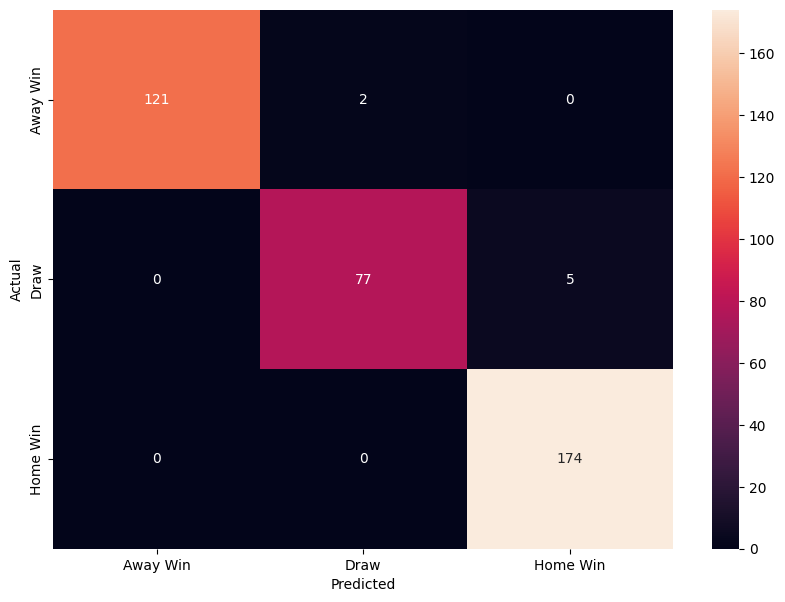

In [46]:
# confusion matrix

confusion_matrix(y_test, predictions)

# importing the packages for the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5, 2.5], ['Away Win', 'Draw', 'Home Win'])
plt.yticks([0.5, 1.5, 2.5], ['Away Win', 'Draw', 'Home Win'])
plt.show()